# Performance as a function focal plane position

Authors: Keith Bechtol and Angelo Fausti

Date: 31 May 2018

Stack Version: weekly 2018_21

The goal of this notebook is to demonstrate methods to compile performance metrics from a set of individual visits and assemble as a function focal plane position (sensor number or x,y position in instrument coordinates).

In [1]:
import numpy as np
import pandas as pd

import lsst.daf.persistence as daf_persistence

%matplotlib inline
import matplotlib.pyplot as plt

HSC PDR1

Information available here: https://confluence.lsstcorp.org/display/DM/S18+HSC+PDR1+reprocessing

The output repos are:

/datasets/hsc/repo/rerun/DM-13666/UDEEP/
/datasets/hsc/repo/rerun/DM-13666/DEEP/
/datasets/hsc/repo/rerun/DM-13666/WIDE/


In [2]:
band = 'HSC-R'
depth = 'WIDE' # WIDE, DEEP, UDEEP
field = 'SSP_WIDE'
outfile = 'focal_plane_df.h5'
butler = daf_persistence.Butler('/datasets/hsc/repo/rerun/DM-13666/%s/'%(depth))

/opt/lsst/software/stack/python/miniconda3-4.3.21/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


As a side note, you can find out all the field names in SSP with the following command

In [3]:
unique_visits = butler.queryMetadata('src', ['field'])
[ field for field in unique_visits if 'SSP' in field ]

['SSP_WIDE',
 'SSP_UDEEP_SXDS',
 'SSP_UDEEP_COSMOS',
 'SSP_DEEP_DEEP2_3',
 'SSP_AEGIS',
 'SSP_DEEP_COSMOS',
 'SSP_DEEP_ELAIS_N1',
 'SSP_DEEP_XMM_LSS',
 'SSP_DEEP_XMMS_LSS']

In [4]:
unique_visits = butler.queryMetadata('src', ['visit'], dataId={'filter':band, 'field':field})
print('Found %i unique visits in %s band %s depth survey'%(len(unique_visits), band, depth))

Found 818 unique visits in HSC-R band WIDE depth survey


In [5]:
subset = butler.subset('src', dataId={'filter':band, 'field':field})

In [6]:
"""
def getSrcFullFocalPlane(visit, band):
    subset = butler.subset('src', **{'filter':band, 'visit':visit})
    #print(len(subset.cache))
    df_array =[]
    for dataid in subset.cache:
        if butler.datasetExists('src', dataId=dataid):
            #print('It exists:', dataid['ccd'])
            src = butler.get('src', dataId=dataid)
            df_array.append(src.asAstropy().to_pandas())
            #data = {'x': src.getX(),
            #        'y': src.getY()}
            #df_array.append(pd.DataFrame(data=data))
            #df_array[-1] = df_array[-1].assign(visit = dataid['visit'])
            #df_array[-1] = df_array[-1].assign(ccd = dataid['ccd'])
            df_array[-1]['visit'] = dataid['visit']
            df_array[-1]['ccd'] = dataid['ccd']
        else:
            pass
            #print('No go:', dataid['ccd'])
            
    return pd.concat(df_array)
"""

"\ndef getSrcFullFocalPlane(visit, band):\n    subset = butler.subset('src', **{'filter':band, 'visit':visit})\n    #print(len(subset.cache))\n    df_array =[]\n    for dataid in subset.cache:\n        if butler.datasetExists('src', dataId=dataid):\n            #print('It exists:', dataid['ccd'])\n            src = butler.get('src', dataId=dataid)\n            df_array.append(src.asAstropy().to_pandas())\n            #data = {'x': src.getX(),\n            #        'y': src.getY()}\n            #df_array.append(pd.DataFrame(data=data))\n            #df_array[-1] = df_array[-1].assign(visit = dataid['visit'])\n            #df_array[-1] = df_array[-1].assign(ccd = dataid['ccd'])\n            df_array[-1]['visit'] = dataid['visit']\n            df_array[-1]['ccd'] = dataid['ccd']\n        else:\n            pass\n            #print('No go:', dataid['ccd'])\n            \n    return pd.concat(df_array)\n"

In [7]:
"""
#subset = butler.subset('calexp', **{'filter':band, 'visit':unique_visits[0]})
#for ii in range(0, len(subset.cache)):
#    src = butler.get('src', **subset.cache[ii])
#butler.queryMetadata('calexp', ['visit', 'ccd', 'filter'], dataId={'filter':band, 'visit':unique_visits[0]})

n_visits = 2
df_array = []
for ii in range(0, n_visits):
    print('Visit = %i'%(unique_visits[ii]))
    df_array.append(getSrcFullFocalPlane(unique_visits[ii], band))
    #src = butler.get('src', dataId={'visit':unique_visits[ii], 'filter':band, 'ccd':0})
    
df = pd.concat(df_array)
"""

"\n#subset = butler.subset('calexp', **{'filter':band, 'visit':unique_visits[0]})\n#for ii in range(0, len(subset.cache)):\n#    src = butler.get('src', **subset.cache[ii])\n#butler.queryMetadata('calexp', ['visit', 'ccd', 'filter'], dataId={'filter':band, 'visit':unique_visits[0]})\n\nn_visits = 2\ndf_array = []\nfor ii in range(0, n_visits):\n    print('Visit = %i'%(unique_visits[ii]))\n    df_array.append(getSrcFullFocalPlane(unique_visits[ii], band))\n    #src = butler.get('src', dataId={'visit':unique_visits[ii], 'filter':band, 'ccd':0})\n    \ndf = pd.concat(df_array)\n"

In [8]:
#df.ccd

In [9]:
df_array = [] 
#visits = unique_visits[0:10]
visits = unique_visits[0:4]
for dataid in subset.cache:
    if dataid['visit'] in visits and butler.datasetExists('src', dataid):
        print("Loading Visit: {}, CCD: {}".format(dataid['visit'], dataid['ccd']))
        df = butler.get('src', dataid).asAstropy().to_pandas()
        df['visit'] = dataid['visit']
        df['ccd'] = dataid['ccd']
        df_array.append(df)

df = pd.concat(df_array)

Loading Visit: 7110, CCD: 89
Loading Visit: 7116, CCD: 44
Loading Visit: 7110, CCD: 32
Loading Visit: 7110, CCD: 39
Loading Visit: 7116, CCD: 24
Loading Visit: 7114, CCD: 37
Loading Visit: 7112, CCD: 76
Loading Visit: 7110, CCD: 5
Loading Visit: 7112, CCD: 13
Loading Visit: 7112, CCD: 19
Loading Visit: 7116, CCD: 84
Loading Visit: 7114, CCD: 76
Loading Visit: 7116, CCD: 33
Loading Visit: 7116, CCD: 61
Loading Visit: 7114, CCD: 8
Loading Visit: 7114, CCD: 97
Loading Visit: 7112, CCD: 59
Loading Visit: 7112, CCD: 6
Loading Visit: 7114, CCD: 93
Loading Visit: 7112, CCD: 63
Loading Visit: 7114, CCD: 1
Loading Visit: 7110, CCD: 61
Loading Visit: 7114, CCD: 25
Loading Visit: 7112, CCD: 82
Loading Visit: 7112, CCD: 25
Loading Visit: 7116, CCD: 31
Loading Visit: 7114, CCD: 82
Loading Visit: 7114, CCD: 33
Loading Visit: 7114, CCD: 60
Loading Visit: 7114, CCD: 39
Loading Visit: 7112, CCD: 51
Loading Visit: 7112, CCD: 8
Loading Visit: 7114, CCD: 3
Loading Visit: 7116, CCD: 37
Loading Visit: 7110,

In [10]:
df.to_hdf(outfile, 'df')

In [11]:
df = pd.read_hdf(outfile, 'df')

In [12]:
#for column in df.columns: print(column)
#list(df.columns.values)

In [13]:
xx = df.slot_PsfShape_xx
yy = df.slot_PsfShape_yy
xy = df.slot_PsfShape_xy
df['psf_trace_radius'] = np.sqrt((xx + yy) / 2.)
df['psf_determinant_radius'] = (xx * yy - xy * xy)**(1. / 4.)

In [14]:
def ellipticity(I_xx, I_xy, I_yy):
    """Calculate ellipticity from second moments.
    Parameters
    ----------
    I_xx : float
    I_xy : float
    I_yy : float
    Returns
    -------
    e, e1, e2 : (float, float, float) or (numpy.array, numpy.array, numpy.array)
        Complex ellipticity, real component, imaginary component
    """

    e = (I_xx - I_yy + 2j*I_xy) / (I_xx + I_yy + 2*cmath.sqrt(I_xx*I_yy - I_xy*2))
    e1 = e.real
    e2 = e.imag
    return e, e1, e2

In [15]:
#restricted_columns = ['']
#sources_df.query(cut)[restricted_columns]
#df_stars = sources_df.query(cut)[restricted_columns]

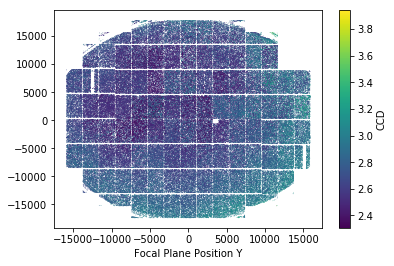

In [16]:
plt.figure()
#c = df.ccd
#c = df.base_PixelFlags_flag_edge
c = df.psf_determinant_radius
#plt.scatter(df.base_FPPosition_x, df.base_FPPosition_y, c=df.ccd, edgecolor='none', marker='.', s=1)
#plt.scatter(df.base_FPPosition_x, df.base_FPPosition_y, c=df.base_PixelFlags_flag_edge, edgecolor='none', marker='.', s=1)
plt.scatter(df.base_FPPosition_x, df.base_FPPosition_y, c=c, edgecolor='none', marker='.', s=1)
plt.colorbar(label='CCD')
plt.xlabel('Focal Plane Position X')
plt.xlabel('Focal Plane Position Y')